<a href="https://colab.research.google.com/github/ajaynain-eng/Hyperspectral-Image-Classification/blob/main/Attention-models/AlexNet/AlexNet_with_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Working with AlexNet**

In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 4.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd           # for csv files and dataframes
import numpy as np            # Linear Algebra tools
import matplotlib.pyplot as plt  # for ploting graphs and curve
from matplotlib import colors, cm, gridspec
import scipy.io as si         # for inputing matlab files
from random import shuffle    # for shuffling dataset
import seaborn as sns
import math
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix   #Confusion matrix creation
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report

import datetime
import time
import os
import gc
import math

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Add,Multiply, Reshape, Dense, Activation, BatchNormalization, Flatten, Dropout, concatenate, Conv2DTranspose, Lambda, multiply
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D,  GlobalAveragePooling2D, GlobalAvgPool2D, DepthwiseConv2D, SeparableConv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import glorot_uniform, Ones
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

import spectral

np.random.seed(1337)          # to get reproducible results
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet"

In [ ]:
# The line of code will run only if we are using gpu
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found') 
else:
    print('Found GPU at : ', device_name)

Found GPU at :  /device:GPU:0


In [ ]:
H, W, B = 1101, 566, 49             # height,width and band of image
# keep ps=7 in this file
P_S = 7                          # patch size (window size)
train_percent = 75
epoch = 200

In [ ]:
mat_x = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full.mat')['full']           # shape 623166*372
mat_y = si.loadmat('/content/drive/My Drive/m_p/data/372 band/full_gt.mat')['full_gt']     # shape 623166*1
selective_bands = [0, 53, 56, 70, 71, 103, 106, 113, 115, 116, 117, 142, 174, 188, 195, 198, 200, 201, 203, 205, 207, 238, 239, 254, 264, 266, 272, 274, 281, 282, 
                   284, 285, 292, 293, 296, 298, 301, 303, 310, 313, 315, 337, 341, 342, 343, 345, 346, 349, 369]

mat_x[mat_x < 0.0] = 0.0
mat_x[mat_x > 1.0] = 1.0
print("minimum value in mat_x is :", mat_x.min())
print("maximum value in mat_x is :", mat_x.max())
mat_x = mat_x[:, selective_bands]
x, y = np.array(mat_x), np.array(mat_y)
x, y = x.reshape(H,W,B), y.reshape(H,W)


x = x.astype('float16')
# for i in range(B):
#   x[:,:,i] /= np.max(x[:,:,i])

pad_width = int((P_S-1)/2)
padded_x = np.pad(x,[(pad_width,pad_width),(pad_width,pad_width),(0,0)],'edge')
# np.save("/content/drive/MyDrive/Personal Folder for training/padded_x.npy" , padded_x)
X,Y = [],[]
for a in range(H):
  for b in range(W):
    if(y[a][b]!= 0):
      patch = padded_x[a:a+P_S,b:b+P_S,:]
      X.append(patch)
      Y.append(y[a][b]-1)

output_classes = len(np.unique(y))-1

print("\n")
print("shape of mat_x: ", mat_x.shape)
print("shape of mat_y: ", mat_y.shape)
print("shape of x: ", x.shape)
print("shape of y: ", y.shape)

minimum value in mat_x is : 0.0
maximum value in mat_x is : 1.0


shape of mat_x:  (623166, 49)
shape of mat_y:  (623166, 1)
shape of x:  (1101, 566, 49)
shape of y:  (1101, 566)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=(train_percent/100),stratify=Y, random_state=10)
x_train,x_test,y_train,y_test = np.array(x_train),np.array(x_test),np.array(y_train),np.array(y_test)
print(f"x_train shape: {x_train.shape} \ny_train shape: {y_train.shape} \nx_test shape: {x_test.shape} \ny_test shape: {y_test.shape}")

x_train shape: (5886, 7, 7, 49) 
y_train shape: (5886,) 
x_test shape: (1963, 7, 7, 49) 
y_test shape: (1963,)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), array([ 668,  128,  192,  337,  259,  174,  753,  181,  190,  404, 1033,
        404, 1163]))


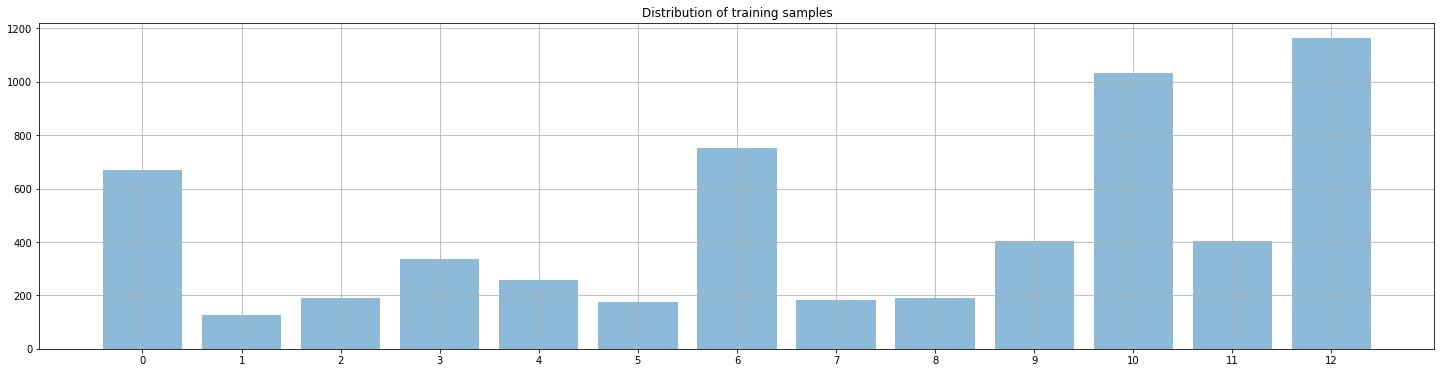

In [ ]:
plt.figure(figsize = (25, 6))
u_c = np.unique(y_train,return_counts=True)
print(u_c)
plt.bar( u_c[0],u_c[1], align='center', alpha=0.5)
plt.title('Distribution of training samples')
plt.xticks(np.arange(0,u_c[0].shape[0]))
plt.grid()
plt.show()
del u_c

In [ ]:
# del un-necessary data as it is consuming around 3 GB of RAM
# Note memory, runtime, accuracy is everything in Data Science
del mat_x, mat_y, x, y, X, Y

## **Defining Functions**

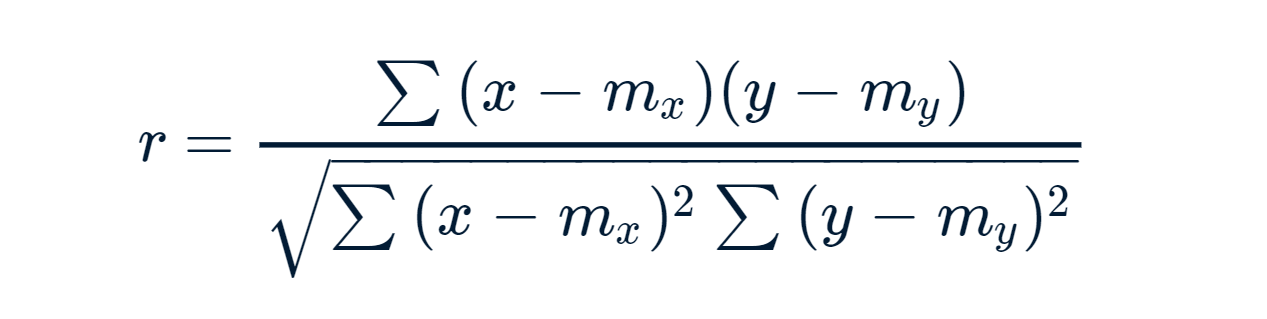

In [ ]:
def masked_correlation(gus_k, X, channels = 64, P_S = 11):
    loc = P_S//2
# Working as per the above formula to calculate Pearson correlation coefficient.
# For all the operations I have avoided any kind of loop as loops are slow (written in python). Numpy array (written in C) and Tensors are very fast.
# Here we are interested to use highly correlated spatial information around central pixels. we will consider the surrounding spatial information based on their correlation

    x_mean = tf.math.reduce_mean(X, axis = -1, keepdims=True)
    x_mean = tf.repeat(x_mean, repeats = channels, axis = -1)

    y = X[:,loc:loc+1, loc:loc+1, :]
    y = tf.repeat(y, repeats = P_S, axis = -2)
    y = tf.repeat(y, repeats = P_S, axis = -3)

    y_mean = tf.math.reduce_mean(y, axis = -1, keepdims = True)
    y_mean = tf.repeat(y_mean, repeats = channels, axis = -1)

    a = tf.math.subtract(X, x_mean)
    b = tf.math.subtract(y, y_mean)
    ab = tf.math.multiply(a,b)
    num = tf.math.reduce_sum(ab, axis = -1, keepdims = True)                        # Numerator

    a_new = tf.math.reduce_sum(tf.math.multiply(a,a), axis = -1, keepdims = True)
    b_new = tf.math.reduce_sum(tf.math.multiply(b,b), axis = -1, keepdims = True)
    deno = tf.math.sqrt(tf.math.multiply(a_new, b_new))                             # Denominator
 
    corr = tf.math.divide(num, deno)                                                # Pearson correlation coefficient

    thresh = tf.math.reduce_mean(corr)                                      # Consider the surrounding spatial info showing correlation value higher than a certain threshold.
    mask = corr > thresh                                                    # Forming a mask for selecting spatial information [1 if to select otherwise 0 ]
    mask = tf.cast(mask, corr.dtype)

    masked_corr = tf.math.multiply(mask, corr)
    # gus_k = tf.expand_dims(gus_k, axis = -1) 
    # gus_k = gus_k.reshape(P_S, P_S, 1)                     
    # masked_corr = tf.math.multiply(masked_corr, gus_k)          # Further scaling the selected spatial information based on their distance from centre (apply gaussion filter)
  
    attention_weights = tf.repeat(masked_corr, repeats = channels, axis = -1)
    X = Multiply()([X, attention_weights])
    return X

In [ ]:
def Spatial_attention_0(inputs):
    shape = inputs.shape
    k_size = shape[-2]
    x = Conv2D(filters=1, kernel_size=(k_size, k_size), padding='same')(inputs) # to aggregate the Spatial information. Generating 2D feature map.
    x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=1, kernel_size=(k_size, k_size), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(k_size, k_size), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(k_size, k_size), padding='same')(x)
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    x = multiply([inputs, x])
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    return x
def Spatial_attention(x, filter):
    input = x
    shape = x.shape
    # x = Conv2D(filters=filter, kernel_size=(1,1), padding='same')(x)
    # x = BatchNormalization()(x)
    # Applying 2D convolution to derive a spatial attention.
    x = Conv2D(filters=filter, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(x)     # kernel_regularizer=l2(5e-4)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=filter, kernel_size=(3,3), strides = (2,2), padding='same')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=1, kernel_size=(3,3), strides = (2,2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(filters=filter, kernel_size=(3,3), strides=(2, 2), padding='same')(x)
    # x = Activation('relu')(x)
    if shape != x.shape:
        k_size = x.shape[-3] - shape[-3] + 1
        x = Conv2D(filter, kernel_size=k_size, strides=(1, 1), padding='valid')(x)
    else:
        pass
    x = Activation('sigmoid')(x) 
    # x = Conv2D(filters = filter, kernel_size=(1,1), kernel_initializer=Ones())(x)
    # x = tf.repeat(x, repeats = filter, axis = -1)
    # Sigmoid is used as activation so that pixel with very less information can be converted to nearby zero and highly important to nearly 1
    # Further multiplication with initial spatial features will keep highly important features and minimize the others less important features to zero (approx)
    x = Multiply()([input, x])
    # x = add([output, input])
    return x

In [ ]:
# def Spectral_attention(x, filters):
#     shape = x.shape
#     # Averagepooling the features along channel. (shape = 1*1*channels or bands). 1D vector representing bands info.
#     # Now we have 1 value per channel/band. After training we would have high value in vector corresponding to highly important band.
#     x = GlobalAveragePooling2D(data_format='channels_last', keepdims=True)(x)
#     x = Conv2D(filters=filters, kernel_size=(1,1))(x)
#     x = Activation('relu')(x)
#     x = Conv2D(filters=filters, kernel_size=(1,1))(x)
#     x = Activation('sigmoid')(x)
#     # Sigmoid is used as activation so that value in vector corresponding to different bands can be altered as per their importance.
#     x = UpSampling2D(size=(shape[1], shape[2]))(x) # Upsample the array to match the origional feature metrix
#     return x
def channel_attention_block(input, filters, kernel_size, padding, reduction_ratio, weight_decay=5e-4):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, use_bias=False, kernel_initializer='he_normal')(input)    # kernel_regularizer=l2(weight_decay)
    x = BatchNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    squeeze = Conv2D(filters=filters//reduction_ratio, kernel_size=(1,1), padding=padding, use_bias=False, kernel_initializer='he_normal')(x)
    squeeze = Activation('relu')(squeeze)
    excitation = Conv2D(filters=filters, kernel_size=(1,1), use_bias=False, padding=padding, kernel_initializer='he_normal')(squeeze)
    excitation = Activation('sigmoid')(excitation)
    return excitation

def Spectral_attention(input, filters, cardinality = 3):
    group_list = []
    grouped_channels = filters//cardinality        # As some bands/channels may be more important than their neighbours and at the same time less important than distants.
    for c in range(cardinality):                     # We will consider band importance in their neighbours (generate subsets of bands and then apply attention)
        if c<cardinality-1:
            x = Lambda(lambda z: z[:, :, :, c * grouped_channels:(c + 1) * grouped_channels])(input)
        else:
            x = Lambda(lambda z: z[:, :, :, c * grouped_channels:])(input)
            grouped_channels = x.shape[-1]
        # x = Conv2D(grouped_channels, (3, 3), padding='same', use_bias=False, strides=(1, 1), kernel_initializer='he_normal')(x)
        x_channel = channel_attention_block(x, filters=grouped_channels, kernel_size=3, padding='same', reduction_ratio=2)
        group_list.append(x_channel)

    # collecting all the data again
    group_merge = concatenate(group_list, axis=-1)
    x = multiply([input, group_merge])
    x = BatchNormalization(axis=-1)(x)
    # print("finally shape: ", x.shape)
    return x

In [ ]:
def apply_attention(X, Spe_A, Spa_A):
    F_A = Multiply()([X, Spe_A])  # Multiplication operation will generate scaled output based on Spectral importance
    F_B = Multiply()([X, Spa_A])  # Multiplication operation will generate scaled output based on Spatial importance
        # X = Add()([X, F_A, F_B])      # Adding all the output(convolution, Spectral, Spatial) from the block
    X = Add()([F_A, F_B])
    X = BatchNormalization()(X)
    return X

In [ ]:
# def AlexNet(input_shape = (P_S,P_S,B), use_attention = True):
#     x_input = Input(input_shape)
#     x = Conv2D(filters=96, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x_input)
#     # if use_attention:
#     #     Spa_A = Spatial_attention(x, 96)
#     #     x_input = Multiply()([x_input, Spa_A])
#     x = Conv2D(filters=256, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
#     x = Conv2D(filters=384, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
#     x = Conv2D(filters=384, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
#     if use_attention:
#         Spe_A = Spectral_attention(x, 384)
#         x = Multiply()([x, Spe_A])

#     x = Conv2D(filters=256, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
#     if use_attention:
#         Spe_A = Spectral_attention(x, 256)
#         Spa_A = Spatial_attention(x, 256)
#         x = apply_attention(x, Spe_A, Spa_A)
#         # x = Multiply()([x, Spe_A])

#     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
#     if use_attention:
#         Spe_A = Spectral_attention(x, 256)
#         Spa_A = Spatial_attention(x, 256)
#         x = apply_attention(x, Spe_A, Spa_A)
#     #     x = Multiply()([x, Spa_A])
#     # if use_attention:
#     #     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
#     #     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
#     #     # x = Conv2D(filters=13, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
#     #     Spe_A = Spectral_attention(x, 256)
#     #     x = Multiply()([x, Spe_A])
        
#     x = Flatten()(x)
#     # x = Dense(4096, activation='relu')(x)
#     # x = Dropout(0.4)(x)
#     x = Dense(512, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(256, activation='relu')(x)
#     x = Dropout(0.4)(x)
#     x = Dense(output_classes,activation='softmax')(x)
#     model = Model(inputs = x_input, outputs = x, name = "AlexNet")
#     return model

In [ ]:
def AlexNet(input_shape = (P_S, P_S, B), classes = output_classes, use_attention = True, use_pearson_corr = True, gus_k = None):
    x_input = Input(input_shape)
    if use_pearson_corr:
        x = masked_correlation(gus_k, x_input, channels = B, P_S = P_S)
        x = Spatial_attention_0(x)
        x = Conv2D(filters=64, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x) 
    else:
        x = Conv2D(filters=64, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x_input)
    # if use_pearson_corr and (not use_attention):
    #     x = masked_correlation(gus_k, x_input, channels = B, P_S = P_S)
    if use_attention:
        x = Spatial_attention(x, 64)
        x = Spectral_attention(x, 64, cardinality = 4)
    # if use_attention:
    #     Spa_A = Spatial_attention(x, 96)
    #     x_input = Multiply()([x_input, Spa_A])
    x = Conv2D(filters=64, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
    if use_attention:
        x = Spatial_attention(x, 64)
        x = Spectral_attention(x, 64, cardinality = 4)
    x = Conv2D(filters=128, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Conv2D(filters=128, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
    if use_attention:
        x = Spectral_attention(x, 128, cardinality = 8)
    x = Conv2D(filters=64, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
    if use_attention:
        x = Spectral_attention(x, 64, cardinality = 4)

    x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    if use_attention:
        x = Spectral_attention(x, 64, cardinality = 4)
    #     x = Multiply()([x, Spa_A])
    # if use_attention:
    #     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    #     x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
    #     # x = Conv2D(filters=13, activation='relu', kernel_size=(3,3), strides=(1,1), padding='same')(x)
    #     Spe_A = Spectral_attention(x, 256)
    #     x = Multiply()([x, Spe_A])
        
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(output_classes,activation='softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = "AlexNet")
    return model

In [ ]:
def lrfn(epochs):
    LR_START = 0.01
    LR_MAX = 0.01 
    LR_MIN = 0.001
    LR_RAMPUP_EPOCHS = 0
    LR_SUSTAIN_EPOCHS = 0
    EPOCHS = epochs
    STEPS = [epochs,400]
    if epoch<STEPS[0]:
        epoch2 = epochs
        EPOCHS2 = STEPS[0]
    elif epochs<STEPS[0]+STEPS[1]:
        epoch2 = epochs-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epochs<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epochs-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

In [ ]:
def build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path, use_pearson_corr = None, use_attention = True, batch_size = 128, epochs = 100, P_S = P_S, B = B):
    # Generating proper directory for saving the model
    if use_attention:
        dir = folder_path + "/With_Attention/"
        print('You are using attention mechanism.......')
###############
# Constructing Gaussian kernel 
        # sig = P_S//2
        # x = np.linspace(-(P_S/2)/sig, (P_S/2)/sig, P_S+1)
        # kern1d = np.diff(st.norm.cdf(x))
        # kern2d = np.outer(kern1d, kern1d)
        # kern2d = kern2d/kern2d.sum()
        # kern2d = kern2d/kern2d.max()
        gus_k = None
###############
    else:
        dir = folder_path + "/Without_Attention/"
        print('You are not using attention mechanism.......')
        gus_k = None
    try:
        os.makedirs(dir)
    except:
        pass
    filepath= dir + str(train_percent) + "% ps_" + str(P_S) + " AlexNet.hdf5"

    # Building the model
    model = AlexNet(input_shape = (P_S, P_S, B), use_attention = use_attention, use_pearson_corr = use_pearson_corr, gus_k = None)
    plot_model(model, to_file = dir + "model_architecture.jpg", show_shapes=False)
    
    # Compiling the model
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    model.compile(optimizer=optimizers.Adagrad(0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    print('compiling done successfully.......')

    file_dir = os.path.dirname(filepath)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
    callbacks_list = [checkpoint, lr_callback]

    print('starting the training phase....')
    start_time = time.time()
    history = model.fit(x = x_train, y = y_train, validation_data = (x_test,y_test), validation_freq = 1, batch_size = batch_size, 
                        callbacks=callbacks_list, shuffle = False, epochs=epochs, use_multiprocessing = True)
    end_time = time.time()
    tt = end_time - start_time
    tt_min = tt//60
    tt_sec = tt - tt_min*60
    print(f'model trained ████████████████████████████████████████████████████████████████████████ 100% for {epochs} epochs')
    print('\n')
    print(f'total time taken for training is: {tt_min} min, {tt_sec} sec')
    return model, history, tt

In [ ]:
def plot_accuracy_loss_curve(history, folder_path = None, use_attention = True):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    fig = plt.figure(figsize = (24,8))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(train_accuracy, color='black', marker='o', linewidth=2, markersize = 3,  label = 'train_accuracy')
    ax.plot(val_accuracy, color='green', marker='o', linewidth=2, markersize = 3, label = 'val_accuracy')
    ax.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(train_loss, color = 'pink', marker='o', linewidth=2, markersize = 3, label = 'train_loss')
    ax2.plot(val_loss, color = 'red', marker='o', linewidth=2, markersize = 3, label = 'val_loss')
    ax2.grid()
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance')
    ax2.legend()
    plt.show()
    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + "accuracy_loss_curve.jpg"
        fig.savefig(path)

In [ ]:
def plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None):  # Can be used to compare 2 models
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    df = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})
    
    train_loss = history_att.history['loss']
    val_loss = history_att.history['val_loss']
    train_accuracy = history_att.history['accuracy']
    val_accuracy = history_att.history['val_accuracy']

    df_att = pd.DataFrame({'train_loss' : train_loss,
                    'val_loss' : val_loss,
                    'train_accuracy' : train_accuracy,
                    'val_accuracy': val_accuracy})

    fig = plt.figure(figsize=(24,10))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    ax.plot(df[train_or_val + '_accuracy'], color='black', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_accuracy')
    ax.plot(df_att[train_or_val + '_accuracy'], color='green', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_accuracy')
    # if total_to_plot > 2:
    #     ax.plot(df2[train_or_val + '_accuracy'], color='gray', marker='o', linewidth=2, markersize = 8, label = train_or_val + '_accuracy_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('accuracy')
    ax.legend()
    ax2.plot(df[train_or_val + '_loss'], color = 'pink', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_loss')
    ax2.plot(df_att[train_or_val+'_loss'], color = 'red', marker='o', linewidth=1, markersize = 2, label = train_or_val + '_attention_loss')
    # if total_to_plot > 2:
    #     ax2.plot(df2[train_or_val + '_loss'], color = 'orange', marker='o', linewidth=2, markersize = 8, label = train_or_val + 'train_loss_2')
    plt.xlabel('no. of epoches')
    plt.ylabel('loss')
    plt.title('accuracy and loss plot for model performance on ' + train_or_val + ' score')
    ax2.legend()
    plt.show()

    if folder_path:
        dir = folder_path + "/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + train_or_val + " comparision_plot.jpg"
        fig.savefig(path)
    # return fig



In [ ]:
def predict_half_image(model, padded_x, H, W_range, B, P_S):
    y_hat = np.zeros((H,W_range))
    for j in range(W_range):
        patchs = np.zeros((H, P_S, P_S, B))
        for i in range(H):
            patchs[i,:,:,:] = padded_x[i:i+P_S, j:j+P_S, :]
        y_pred = model.predict(patchs)
        y_pred = np.argmax(y_pred,axis=1)+1
        y_hat[:,j] = y_pred
        del patchs
        gc.collect()
    return y_hat

def predict_image(model, padded_x, H, W, B, P_S):
    start_time = time.time()
    half_1 = padded_x.shape[1]//2 + pad_width+1
    half_2 = padded_x.shape[1]//2 - pad_width-1
    padded_x_1st_half = padded_x[:,:half_1, :]
    padded_x_2nd_half = padded_x[:,half_2:, :]
    del padded_x
    gc.collect()

    y_hat = np.zeros((H,W))
    y_hat[:,:W//2] = predict_half_image(model, padded_x_1st_half, H, W//2, B, P_S)
    # del padded_x_1st_half
    print("image predicted ███████████████████████ 50%")
    gc.collect()
    y_hat[:,W//2:] = predict_half_image(model, padded_x_2nd_half, H, W//2, B, P_S)
    # del padded_x_2nd_half
    print("image predicted ██████████████████████████████████████████████ 100%")
    gc.collect()
    end_time = time.time()
    time_taken = end_time - start_time
    time_min = time_taken//60
    time_sec = time_taken - time_min*60
    print(f'total time taken is: {time_min} min {time_sec} sec.')
    y_hat = np.reshape(y_hat, (H,W))
    print("shape of predicted image is: ", y_hat.shape)
    return y_hat

In [ ]:
def performance_meausures(y_test, y_pred, tt, use_attention, folder_path = None, P_S = P_S):
    accuracy = accuracy_score(y_test, y_pred)
    kappa=cohen_kappa_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred).astype('int32')
    cr = classification_report(y_test, y_pred, output_dict=True)
    df_cr = pd.DataFrame(cr).T
    df_score = pd.DataFrame({'accuracy score: ' : [accuracy], 'Cohen_Kappa score: ' : [kappa], "training time: " : tt}).T

    spec = gridspec.GridSpec(ncols = 2, nrows = 2,
                            width_ratios=[1,3], wspace = 0.5,
                            hspace = 0.5, height_ratios=[7,1])
    
    fig = plt.figure(figsize = (24,8))

    ax1 = fig.add_subplot(spec[0])
    ax1.set_title('classification report')
    sns.heatmap(df_cr, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax1)

    ax2 = fig.add_subplot(spec[1])
    ax2.set_title('confusion matrix')
    ax2.set_xlabel('predicted class')
    ax2.set_ylabel('actual class')
    sns.heatmap(cm, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax2)

    ax3 = fig.add_subplot(spec[2])
    sns.heatmap(df_score, cmap = 'Blues', cbar = False, annot = True, fmt=' .5g', ax = ax3)

    if folder_path:
        if use_attention:
            dir = folder_path + "/With_Attention/"
        else:
            dir = folder_path + "/Without_Attention/"
        try:
            os.makedirs(dir)
        except:
            pass
        path = dir + str(train_percent) + "% ps_" + str(P_S) + " Performance.jpg"
        fig.savefig(path)

In [ ]:
def reload_model(folder_path, use_attention, P_S = P_S):
    if use_attention:
        path = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " AlexNet.hdf5"
    else:
        path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " AlexNet.hdf5"
    model = load_model(path)
    return model

## **Attention Model**

In [ ]:
use_attention = True
use_pearson_corr = True
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet"

In [ ]:
model_att, history_att, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, 
                                               use_pearson_corr = use_pearson_corr, use_attention = use_attention, batch_size = 128, epochs = epoch, P_S = P_S, B = B)

You are using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/300
46/46 [==============================] - ETA: 0s - loss: 1.5680 - accuracy: 0.4998
Epoch 1: val_accuracy improved from -inf to 0.19766, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet/With_Attention/75% ps_7 AlexNet.hdf5
46/46 [==============================] - 44s 121ms/step - loss: 1.5680 - accuracy: 0.4998 - val_loss: 2.5456 - val_accuracy: 0.1977 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 2/300
46/46 [==============================] - ETA: 0s - loss: 1.0457 - accuracy: 0.6432
Epoch 2: val_accuracy did not improve from 0.19766
46/46 [==============================] - 3s 63ms/step - loss: 1.0457 - accuracy: 0.6432 - val_loss: 2.5789 - val_accuracy: 0.1136 - lr: 0.

In [ ]:
# filepath = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/ResNet/With_Attention/372 ResNet_ps11.hdf5"
# file_dir = os.path.dirname(filepath)
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='max')
# callbacks_list = [checkpoint]
# model.fit(x = x_train, y = y_train, validation_data = (x_test,y_test), validation_freq = 1, batch_size = 32, 
#           callbacks=callbacks_list, shuffle = False, epochs=50, use_multiprocessing = True)

In [ ]:
model_att.summary()

Model: "AlexNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 7, 7, 49)]   0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 1, 1, 49)    0           ['input_1[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.repeat_1 (TFOpLambda)       (None, 1, 7, 49)     0           ['tf.__operators__.getitem[0][0]'
                                                                 ]                                
                                                                                            

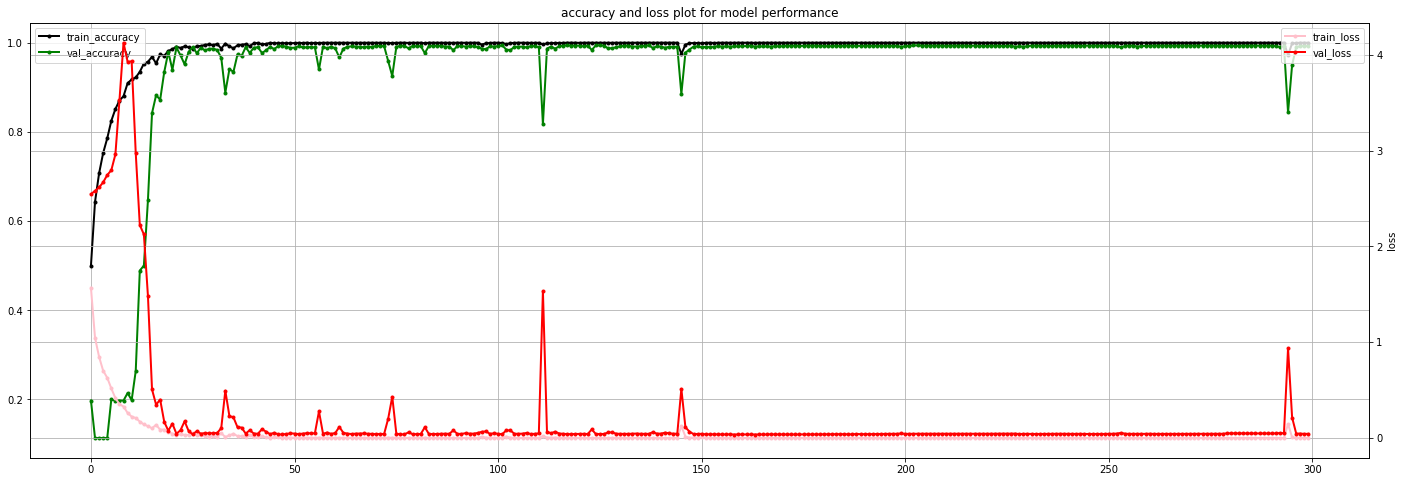

In [ ]:
plot_accuracy_loss_curve(history_att, None, use_attention = use_attention)

In [ ]:
model_att = load_model(folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " AlexNet.hdf5")

In [ ]:
# y_pred = predict(model, x_test)
y_pred = np.argmax(model_att.predict(x_test), axis = 1)

62/62 [==============================] - 2s 14ms/step


In [ ]:
y_pred.shape, y_test.shape

((1963,), (1963,))

In [ ]:
filepath1 = folder_path +"/With_Attention/" + str(train_percent) + "% performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[218   0   0   0   0   0   0   0   0   0   1   0   4]
 [  0  42   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  64   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0   0   0   0   0   1]
 [  0   0   0   0  86   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0  55   1   1   0   0   0   0   1]
 [  0   0   0   0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0  62   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  1   0   0   0   0   0   0   0   0   0   0 134   0]
 [  0   0   0   0   0   2   0   0   0   0   1   0 385]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       223
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        64
           3       1.00      0.99 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/With_Attention/"+str(train_percent)+"%_AlexNet_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

In [ ]:
import gc
gc.collect()

9236

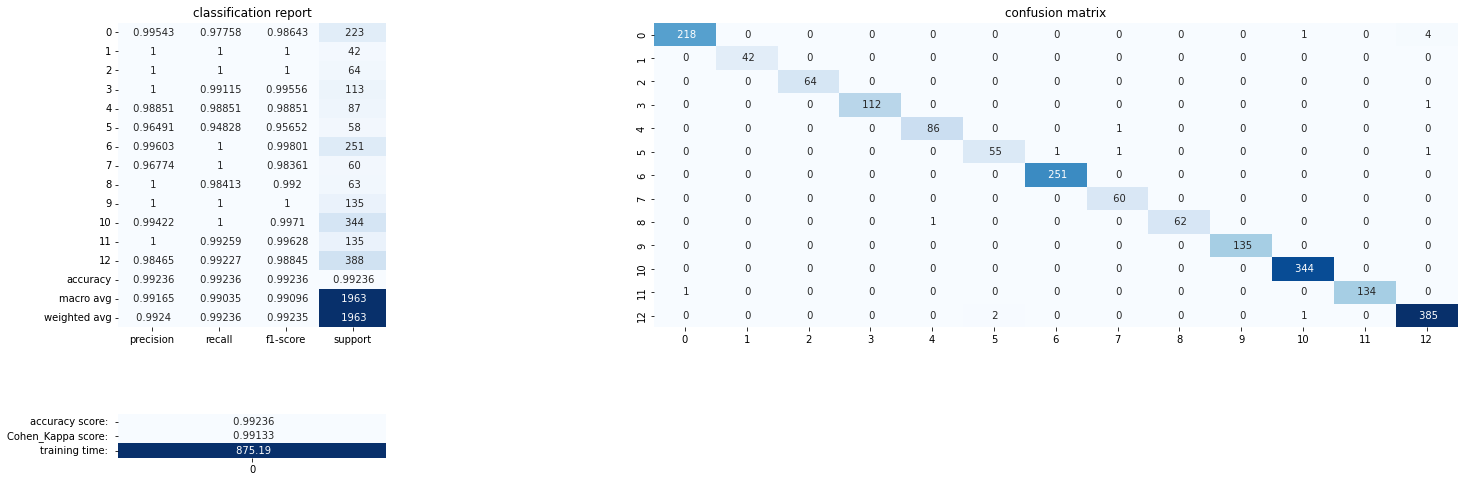

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)

In [ ]:
y_hat = predict_image(model_att, padded_x, H, W, B, P_S)
img_path_att = folder_path + "/With_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path_att, y_hat, colors = spectral.spy_colors)


35/35 [==============================] - 0s 11ms/step
image predicted ███████████████████████ 50%
35/35 [==============================] - 0s 11ms/step
image predicted ██████████████████████████████████████████████ 100%
total time taken is: 8.0 min 13.95410943031311 sec.
shape of predicted image is:  (1101, 566)


In [ ]:
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

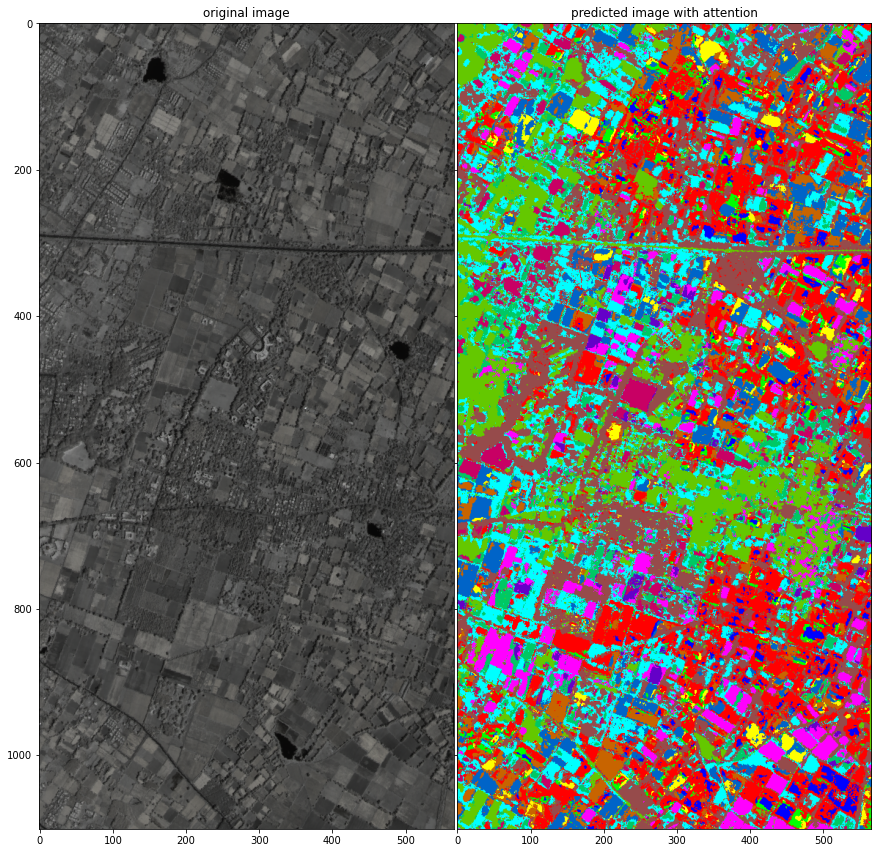

In [ ]:
# img_path = folder_path + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
fig, (ax1, ax2) = plt.subplots(1,2, sharex = True, sharey = True, figsize = (12, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img = plt.imread(img_path_att)
ax2.imshow(img)
ax2.set_title("predicted image with attention")
plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

## **Without Attention**

In [ ]:
use_attention = False
use_pearson_corr = False
folder_path = "/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet"

In [ ]:
model, history, tt = build_compile_and_train_model(x_train, y_train, x_test, y_test, folder_path = folder_path, use_pearson_corr = use_pearson_corr, 
                                               use_attention = use_attention, batch_size = 32, epochs = epoch)

You are not using attention mechanism.......
compiling done successfully.......
starting the training phase....

Epoch 1: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 1/300
184/184 [==============================] - ETA: 0s - loss: 2.1136 - accuracy: 0.3002
Epoch 1: val_accuracy improved from -inf to 0.42741, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet/Without_Attention/75% ps_7 AlexNet.hdf5
184/184 [==============================] - 6s 13ms/step - loss: 2.1136 - accuracy: 0.3002 - val_loss: 1.4524 - val_accuracy: 0.4274 - lr: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.010000000000000002.
Epoch 2/300
180/184 [============================>.] - ETA: 0s - loss: 1.5191 - accuracy: 0.4533
Epoch 2: val_accuracy improved from 0.42741 to 0.48701, saving model to /content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/AlexNet/Wi

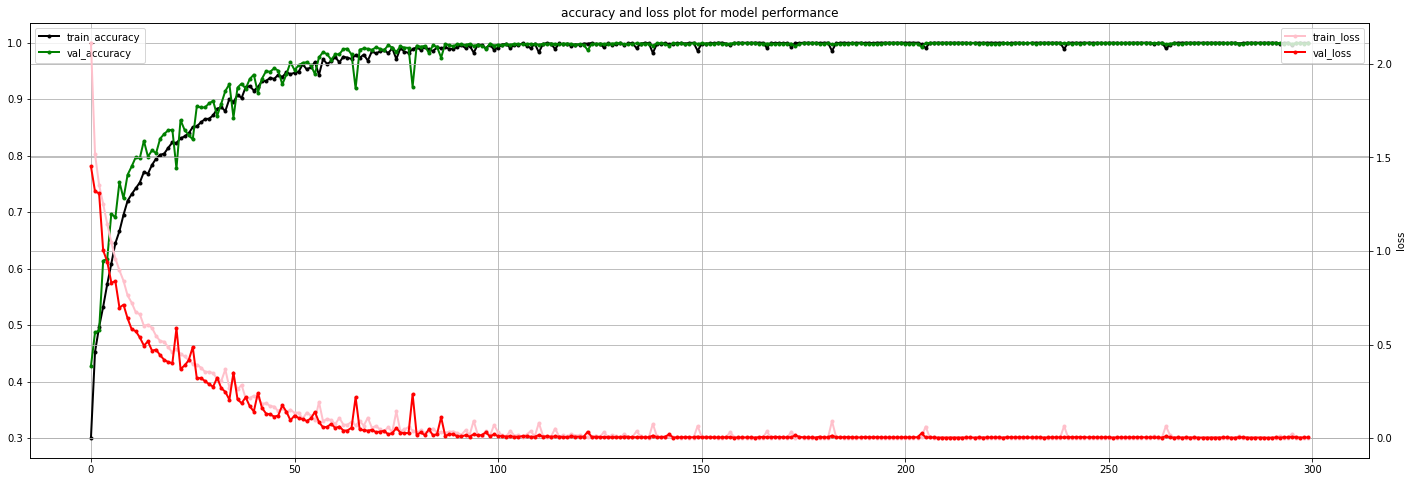

In [ ]:
plot_accuracy_loss_curve(history, None, use_attention = use_attention)

In [ ]:
model_att = load_model(folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " AlexNet.hdf5")

In [ ]:
# y_pred = predict(model, x_test)
y_pred = np.argmax(model.predict(x_test), axis = 1)

62/62 [==============================] - 0s 3ms/step


In [ ]:
filepath1 = folder_path +"/Without_Attention/" + str(train_percent) + "% performance.txt"
results = confusion_matrix(y_test,y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print("P_S = ", P_S, file = open(filepath1, "a"))
print('Confusion Matrix :', file=open(filepath1,"a"))
print(results, file=open(filepath1,"a"))

print('Report : ', file=open(filepath1,"a"))
print(report, file=open(filepath1,"a"))

print('Accuracy Score :', accuracy, file=open(filepath1,"a")) 
print('Cohen_Kappa: ', kappa, file=open(filepath1,"a"))
print('Training Time:', tt, file=open(filepath1,"a"))

print("\033[1m", 'Confusion Matrix :', "\033[0m")
print(results) 
print("\033[1m", 'Report : ', "\033[0m")
print(report)
print("\033[1m", 'Accuracy Score :', "\033[0m", accuracy) 
print("\033[1m", 'Cohen_Kappa: ',  "\033[0m", kappa)
print("\033[1m", 'Training Time:', "\033[0m", tt)

 Confusion Matrix : 
[[223   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0  42   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0  64   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 113   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  87   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  58   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 251   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0   0   0   0   0]
 [  0   0   0   0   1   0   0   0  62   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 135   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0 344   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 135   0]
 [  1   0   0   0   0   0   0   0   0   0   0   0 387]]
 Report :  
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       223
           1       1.00      1.00      1.00        42
           2       1.00      1.00      1.00        64
           3       1.00      1.00 

In [ ]:
y_test = y_test.reshape(y_test.shape[0],1)
y_pred = y_pred.reshape(y_pred.shape[0],1)
y_pred = y_pred.astype(int)
y_combined = np.concatenate((y_test,y_pred),axis=1)

filepath1 = folder_path +"/Without_Attention/"+str(train_percent)+"%_AlexNet_ps"+str(P_S)+".csv"

#img_path = folder_path + "Results/without_corr_"+ str(train_percent) + "%_SAresnet_ps_" +str(P_S) + ".csv"
 #filepath_1 = "/content/drive/My Drive/m_p/CNN Models Comparitive Study/372 band/Simple Models/Results/
np.savetxt(filepath1, y_combined, delimiter=",")

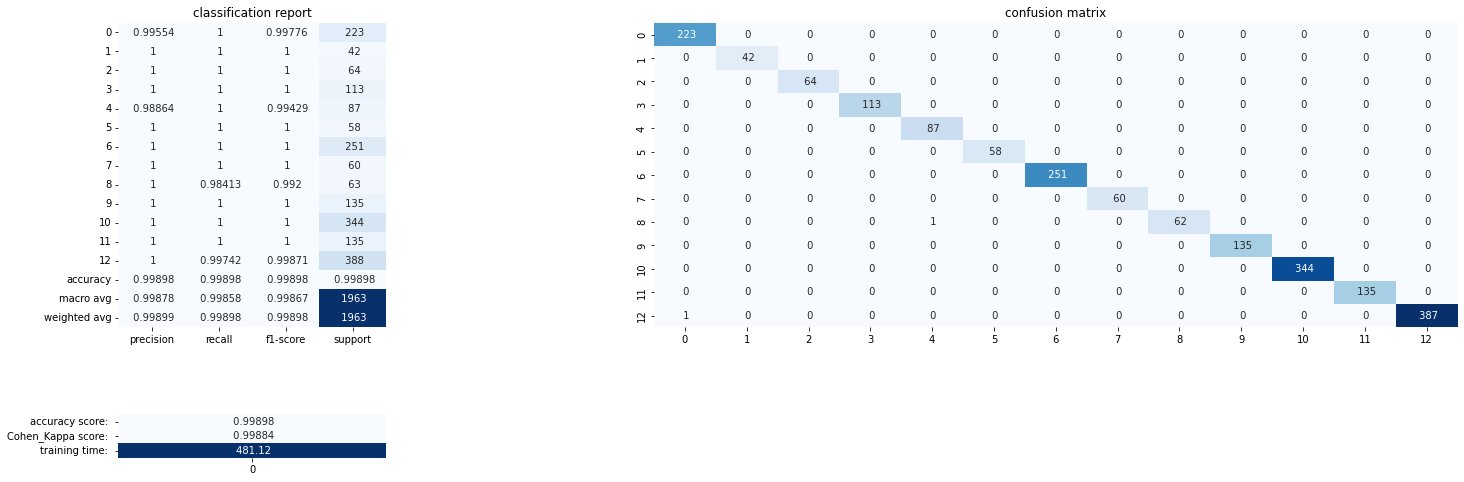

In [ ]:
performance_meausures(y_test, y_pred, tt, use_attention = use_attention, folder_path = folder_path, P_S = P_S)

In [ ]:
y_hat = predict_image(model, padded_x, H, W, B, P_S)
img_path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
spectral.save_rgb(img_path, y_hat, colors = spectral.spy_colors)

35/35 [==============================] - 0s 3ms/step
image predicted ███████████████████████ 50%
35/35 [==============================] - 0s 4ms/step
image predicted ██████████████████████████████████████████████ 100%
total time taken is: 4.0 min 26.035667419433594 sec.
shape of predicted image is:  (1101, 566)


In [ ]:
a_c = np.unique(y_hat,return_counts=True)
print(a_c)
print(a_c,file=open(filepath1,"a"))

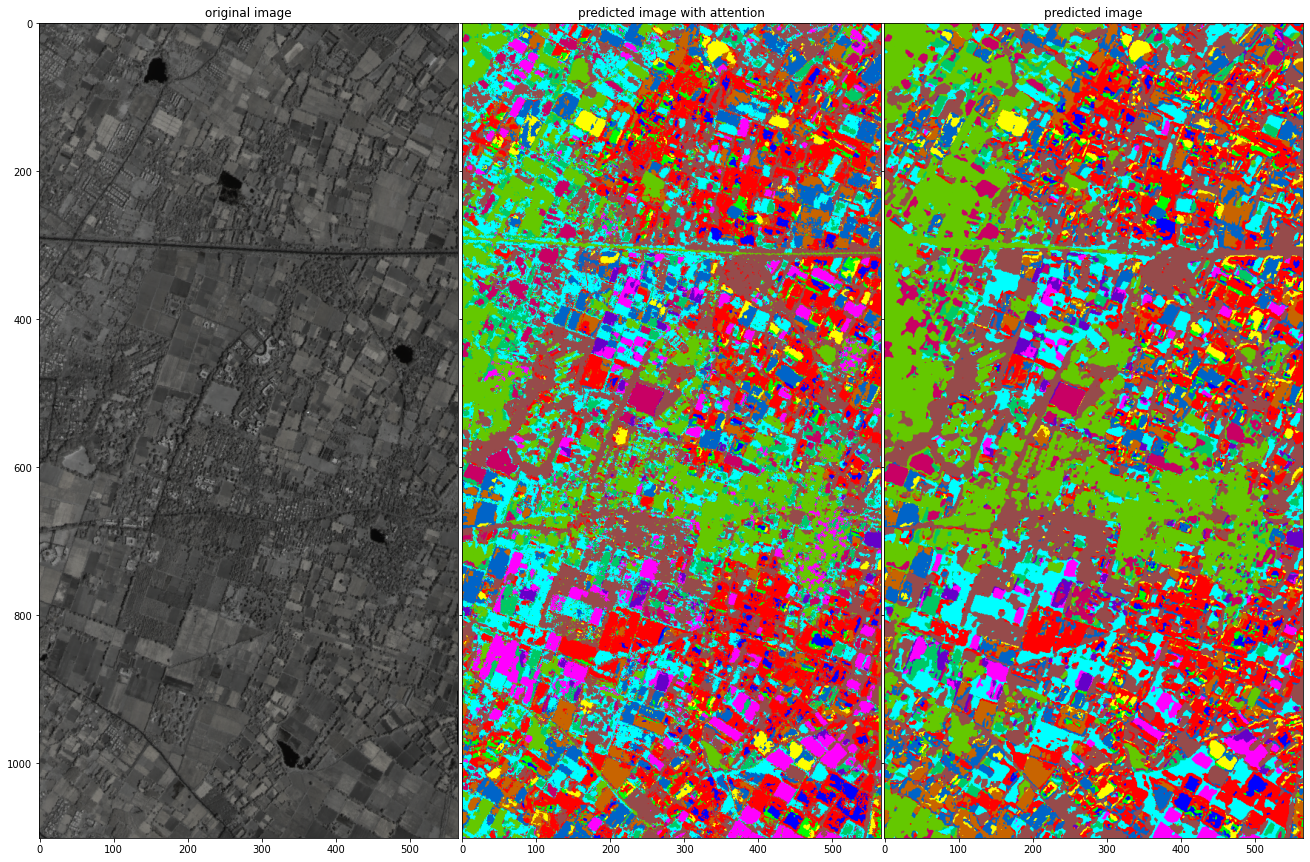

In [ ]:
# img_path = folder_path + "/Without_Attention/" + str(train_percent) + "% ps_" + str(P_S) + " predicted_image.png"
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex = True, sharey = True, figsize = (18, 12))
original_image = plt.imread("/content/drive/MyDrive/m_p/CNN Models Comparitive Study/372 band/Attention on Pretrained Models/Approximate RGB Image.png")
ax1.imshow(original_image)
ax1.set_title("original image")

img_att = plt.imread(img_path_att)
ax2.imshow(img_att)
ax2.set_title("predicted image with attention")

img = plt.imread(img_path)
ax3.imshow(img)
ax3.set_title("predicted image")

plt.tight_layout(pad = 0, h_pad = 0, w_pad = 0)
plt.show()

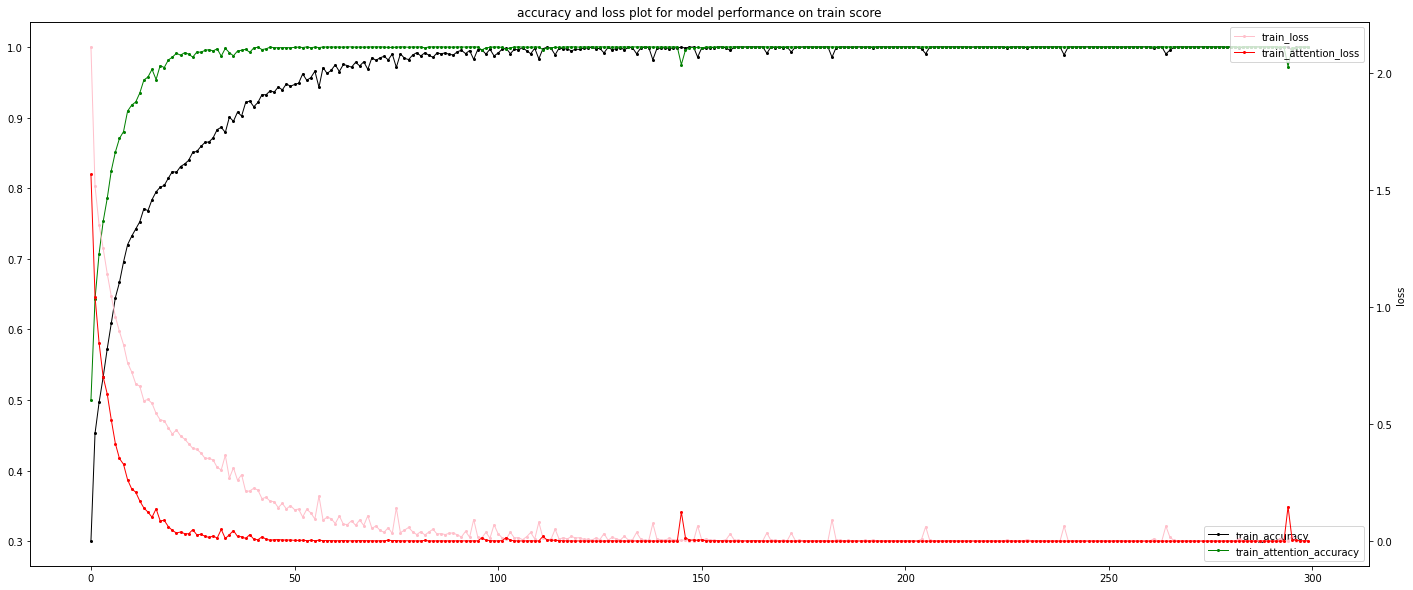

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'train', folder_path = None)

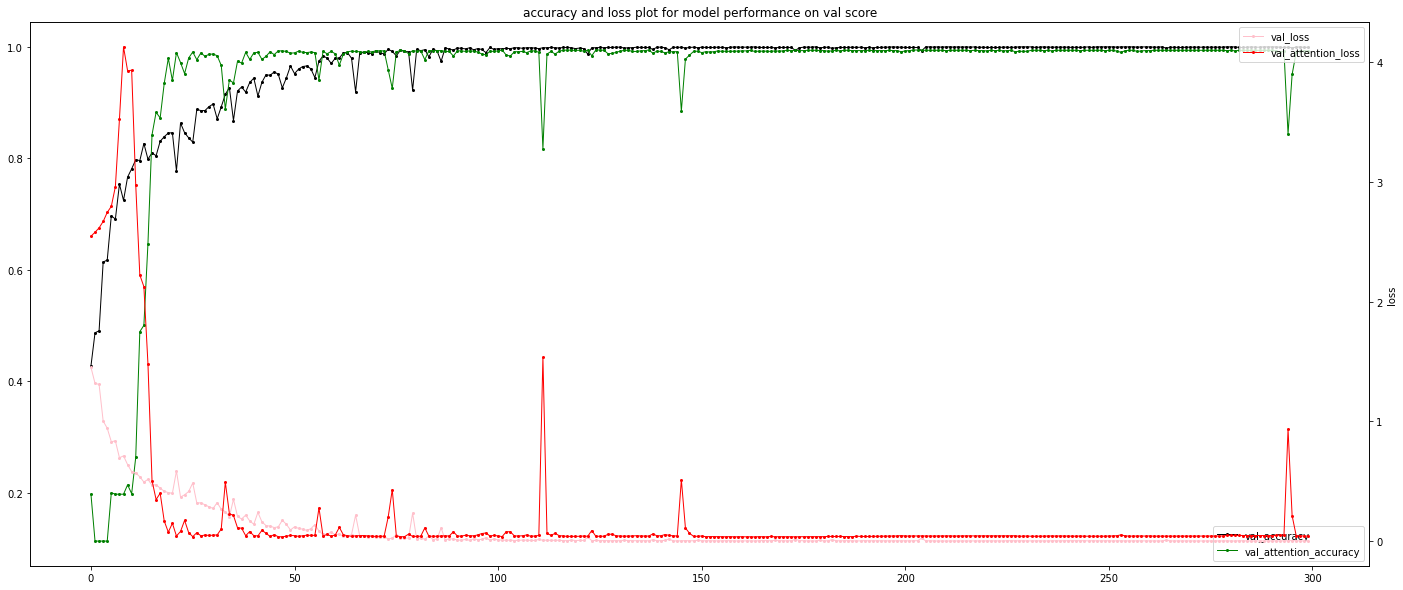

In [ ]:
plot_comparision_plot(history, history_att, train_or_val = 'val', folder_path = None)